In [1]:
import sys

sys.path.insert(0,'/content/drive/MyDrive/Question 5 - ML/src')

from main import generate_master_table
from dataprocessing_py import load_data

In [2]:
data = load_data('/content/drive/MyDrive/Question 5 - ML/training_data.csv', '/content/drive/MyDrive/Question 5 - ML/outlet_info.csv')
data.head()
data.count()

,0
date_id,857269
item_dept,857269
item_qty,857269
net_sales,857269
store,857269
item,857269
profile,857269
size,857269
item_qty_zscore,857269
net_sales_zscore,857269


In [3]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import joblib

In [4]:
def train_and_forecast(master_table):

    # Split the data into train (Nov-Jan) and test (Feb)
    train_data = master_table[master_table.index < '2022-02-01']
    test_data = master_table[master_table.index >= '2022-02-01']

    # Define the feature set and target variable
    feature_columns = [
        'item_qty_lag_1', 'item_qty_lag_7', 'net_sales_lag_1', 'net_sales_lag_7',
        'day_of_week', 'is_weekend', 'month', 'quarter', 'year',
        'store_sales_ratio', 'price_per_item'
    ]

    X_train = train_data[feature_columns]
    y_train = train_data['item_qty']
    X_test = test_data[feature_columns]

    # Setting up the XGBoost model
    model = XGBRegressor(objective='reg:squarederror')

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 500],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_percentage_error', verbose=1)
    grid_search.fit(X_train, y_train)

    # Best model from grid search
    best_model = grid_search.best_estimator_

    # Forecasting for February 2022
    y_pred = best_model.predict(X_test)

    # Adding the predictions to the test data
    test_data['predicted_item_qty'] = y_pred


    # Save the model
    joblib.dump(best_model, 'xgboost_model.pkl')
    print("Model saved as xgboost_model.pkl")

    return test_data

In [5]:
import matplotlib.pyplot as plt

transactions_path = '/content/drive/MyDrive/Question 5 - ML/training_data.csv'
outlet_info_path = '/content/drive/MyDrive/Question 5 - ML/outlet_info.csv'


# Generate the master table
master_table = generate_master_table(transactions_path, outlet_info_path)

# Train the model and forecast
forecasted_data = train_and_forecast(master_table)

# Display the forecasted data
print(forecasted_data[['predicted_item_qty']])


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(forecasted_data.index, forecasted_data['item_qty'], label='Actual')
plt.plot(forecasted_data.index, forecasted_data['predicted_item_qty'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Item Quantity')
plt.title('Forecast vs Actuals for February 2022')
plt.legend()
plt.show()

Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: 

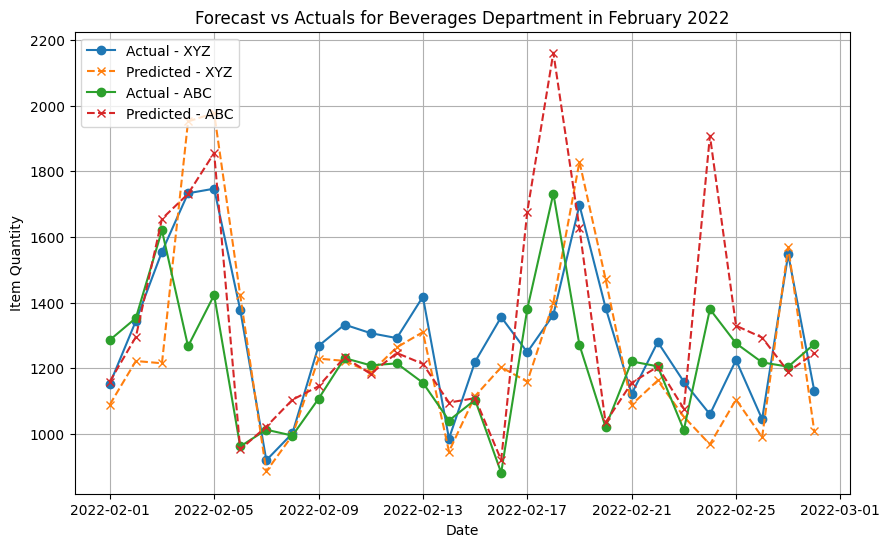

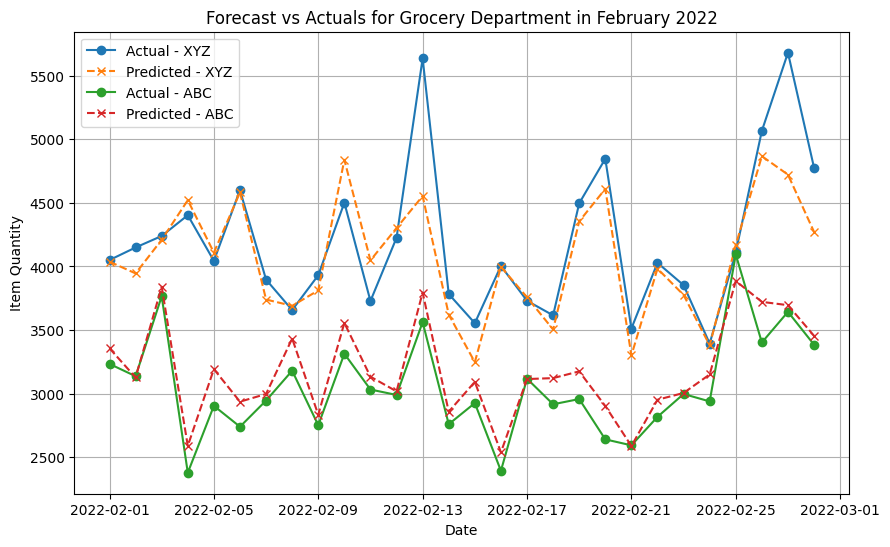

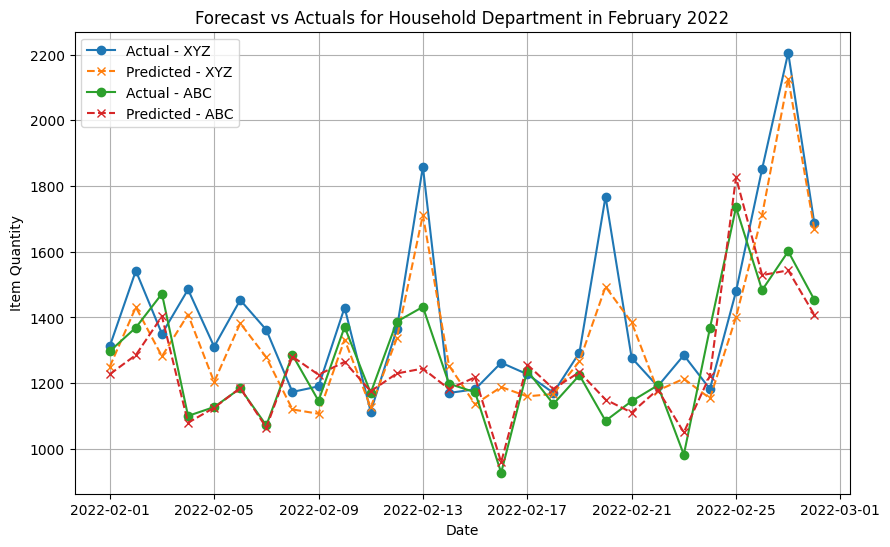

In [ ]:
import matplotlib.pyplot as plt

# Define stores and departments to iterate over
stores = ['XYZ', 'ABC']
departments = ['Beverages', 'Grocery', 'Household']

# Loop through each department
for department in departments:
    plt.figure(figsize=(10, 6))  # Set up the plot size

    # Loop through each store for the current department
    for store in stores:
        # Filter data for the current store and department
        store_department_data = forecasted_data[
            (forecasted_data['store'] == store) & (forecasted_data['item_dept'] == department)
        ]

        # Plot actual vs predicted for the current store and department
        plt.plot(
            store_department_data.index, store_department_data['item_qty'],
            label=f'Actual - {store}', linestyle='-', marker='o'
        )
        plt.plot(
            store_department_data.index, store_department_data['predicted_item_qty'],
            label=f'Predicted - {store}', linestyle='--', marker='x'
        )

    # Add labels, title, and legend
    plt.xlabel('Date')
    plt.ylabel('Item Quantity')
    plt.title(f'Forecast vs Actuals for {department} Department in February 2022')
    plt.legend(loc='upper left')
    plt.grid(True)  # Add gridlines for better readability

    # Show the plot for the current department
    plt.show()


In [6]:
# Calculate MAPE at the specified granularities
def calculate_mape_per_group(df, group_by_columns, actual_col='item_qty', pred_col='predicted_item_qty'):
    grouped = df.groupby(group_by_columns).agg({actual_col: 'sum', pred_col: 'sum'})
    mape = mean_absolute_percentage_error(grouped[actual_col], grouped[pred_col])
    return mape

# Store | Department | Date
mape_store_dept_date = calculate_mape_per_group(forecasted_data, ['store', 'item_dept', 'date_id'])

# Store | Date
mape_store_date = calculate_mape_per_group(forecasted_data, ['store', 'date_id'])

mape_store_dept_date, mape_store_date

NameError: name 'forecasted_data' is not defined